##  <center> Fully discrete Lyapunov consistent discretizations of any order for parabolic reaction-diffusion equations with $r$ species</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import h5py
from glob import glob
import ssdc_io as io
from matplotlib.axis import Axis
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import AnchoredText
from numpy import linalg as LA
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rc('text', usetex=True)
from IPython.display import display, Math, Markdown
plt.rcParams['font.family'].append(u'monospace')
font = {
'family' : 'monospace',
'color'  : 'black',
'weight' : 'normal',
'size'   : 45,
}
fontlabel = {
    'family' : 'monospace',
    'weight' : 'normal',
    'size'   : 45,
}

from matplotlib.ticker import FormatStrFormatter
np.seterr(divide='ignore', invalid='ignore')

import matplotlib
from random import randint
colors = ['#E69F00','#56B4E9', 'magenta','mediumpurple', 'saddlebrown', '#0072B2', '#D55E00', '#CC79A7', '#F0E442','#E13925','#BCDA87', 'black']
colors[0] = '#4c4f96'
colors[1] = 'black'
colors[2] = '#d0ce69'
colors[3] = '#db1c33'
colors[4] = 'gray'
colors[5] =  'saddlebrown'
colors[7] =  "#0b6721"
colors[8] =  "#8e4721"

# !mkdir figs
path='/home/aljahdra/2023-fully-discrete-lyapunov-consistent-discretizations/code/data'
target='/home/aljahdra/2023-fully-discrete-lyapunov-consistent-discretizations/figs'


In [2]:
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
    BboxConnectorPatch

def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches, color=None)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches, color=None)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p




def zoom_effect02(ax1, ax2, **kwargs):

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=2, loc2a=3, loc1b=1, loc2b=4, 
                     prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

## (I) Epidemiological compartmental models. 

1). Temporal evolution of the maximum norm of the solution, $(S,I)$, the Lyapunov functional,$\widetilde{V}$, and its time derivative, $\frac{d\widetilde{V}}{d t}$, for the SI PDE model. 

In [3]:
    file = open(f"{path}/pde-scaled-si-eq.txt", 'r')
    S_eq_e = float(file.readline().split()[1].split('\\')[0])
    I_eq_e = float(file.readline().split()[1].split('\\')[0])
    file.close()

    file = open(f"{path}/pde-scaled-si.txt", 'r')
    t = []
    S = []
    I = []

    time = 2
    susceptible = 6
    infected = 8

    lines = file.readlines()
    file.close()

    for line in lines:
        t += [float(line.split()[time])]
        S += [float(line.split()[susceptible])]
        I += [float(line.split()[infected])]
    
    t1 = []
    L = []
    dL= []

    time1 = 1
    lyap = 2
    dlyap = 3

    file = open(f"{path}/pde-scaled-si-rrk.txt", 'r')
    lines = file.readlines()
    file.close()

    for line in lines:
        t1.append(float(line.split()[time1].split('=')[1]))
        L.append(float(line.split()[lyap].split('=')[1]))
        dL.append(float(line.split()[dlyap].split('=')[1]))

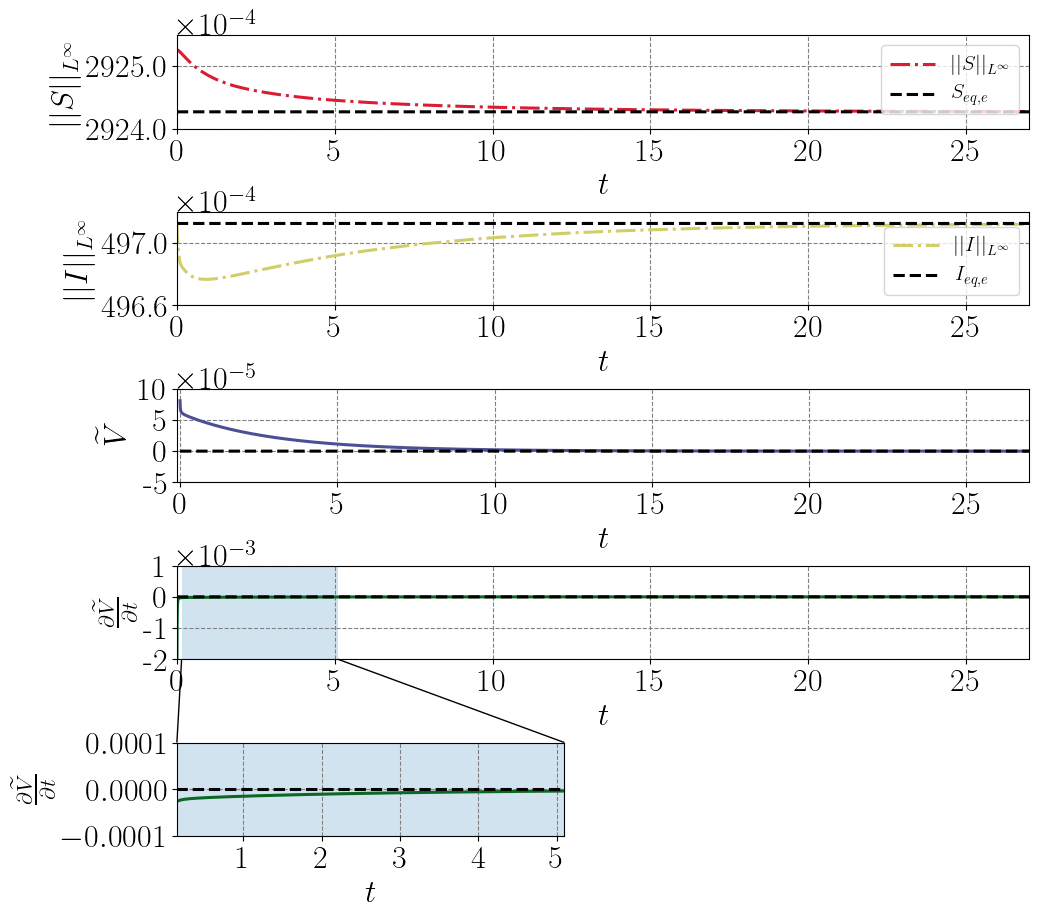

In [4]:
    fig = plt.figure(figsize=(11,15))
    ax = plt.gca()
    rows =7
    columns = 4
    lw=2.2
    grid = plt.GridSpec(rows, columns, wspace = .5, hspace = .89)   
    fontsize_label=23
    legend_size=15

    ax.remove()
    ax =plt.subplot(grid[0, :])
    plt.plot(t, S,'-.',c=colors[3],linewidth = lw)
    plt.plot(t, S_eq_e*np.ones(len(t)), 'k--',linewidth = lw)
    plt.xlim(t[0], t[-1])
    plt.legend(['$||S||_{L^{\infty}}$', '$S_{eq,e}$'],prop={"size":legend_size},loc='upper right',handlelength=2.2,handleheight=0.15,columnspacing=0.25)
    plt.ylabel('$||S||_{L^{\infty}}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.text(0.0, 1.03, r'$\times 10^{-4}$', fontsize=fontsize_label, weight = 'bold',transform = plt.gca().transAxes)
    plt.yticks(locs, map(lambda L: "%1.1f" % L, locs*1e4))
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    ax.set_yticks([0.2925,0.2924])
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
        
        
    ax =plt.subplot(grid[1, :])
    plt.plot(t, I,'-.',c=colors[2],linewidth = lw)
    plt.plot(t, I_eq_e*np.ones(len(t)), 'k--',linewidth = lw)
    plt.xlim(t[0], t[-1])
    plt.legend(['$||I||_{L^{\infty}}$', '$I_{eq,e}$'],prop={"size":legend_size},loc='lower right',handlelength=2.2,handleheight=0.15,columnspacing=0.25)
    plt.ylabel('$||I||_{L^{\infty}}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.text(0.0, 1.03, r'$\times 10^{-4}$', fontsize=fontsize_label, weight = 'bold',transform = plt.gca().transAxes)
    plt.yticks(locs, map(lambda L: "%1.1f" % L, locs*1e4))
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    ax.set_yticks([0.04966,0.04970])
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    ax =plt.subplot(grid[2, :])
    plt.plot(t1, L,c=colors[0],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--', linewidth = lw)
    plt.xlim(t1[0]-0.1, t1[-1])
    plt.ylim(-1e-5, 7.8e-5)
    plt.text(0.0, 1.03, r'$\times 10^{-5}$', fontsize=fontsize_label, weight = 'bold',transform = plt.gca().transAxes)
    plt.ylabel('$\widetilde {V}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda L: "%1.0f" % L, locs*1e5))
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    ax1 =plt.subplot(grid[3, :])
    plt.plot(t1, np.array(dL),c=colors[7],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--',linewidth = lw)
    plt.xlim(t1[0],t1[-1])
    plt.ylim(-2e-3, 1e-3)
    plt.ylabel('$\\frac{\partial \widetilde {V}}{\partial t}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.text(0.0, 1.03, r'$\times 10^{-3}$', fontsize=fontsize_label, weight = 'bold',transform = plt.gca().transAxes)
    plt.yticks(locs, map(lambda L: "%1.0f" % L, locs*1e3))
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    ax2 =plt.subplot(grid[4, 0:2])
    plt.plot(t1, np.array(dL),c=colors[7],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--',linewidth = lw)
    zoom_effect02(ax2, ax1)
    plt.xlim(t1[0],t1[-1])
    plt.ylabel('$\\frac{\partial \widetilde {V}}{\partial t}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    ax2.axis([0.15, 5.1, -0.1e-3,0.1e-3])

    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    plt.savefig(f"{target}/figure1_SI_PDE.pdf", bbox_inches="tight")

2). Temporal evolution of the maximum norm of the solution $(S,E,I)$, and temporal evolution of the Lyapunov functional $\widetilde{V}$ and its time derivative $\frac{d\widetilde{V}}{d t}$ for the SEI PDE model.

In [5]:
    file = open(f"{path}/pde-sei-eq.txt", 'r')
    S_eq_e = float(file.readline().split()[1].split('\\')[0])
    E_eq_e = float(file.readline().split()[1].split('\\')[0])
    I_eq_e = float(file.readline().split()[1].split('\\')[0])
    file.close()

    t = []
    S = []
    E = []
    I = []

    time = 2
    susceptible = 6
    exposed = 8
    infected = 10

    file = open(f"{path}/pde-sei.txt", 'r')
    lines = file.readlines()
    file.close()

    for line in lines:
        t.append(float(line.split()[time]))
        S.append(float(line.split()[susceptible]))
        E.append(float(line.split()[exposed]))
        I.append(float(line.split()[infected]))    
    
    t1 = []
    L = []
    dL= []

    time1 = 1
    lyap = 2
    dlyap = 3

    file = open(f"{path}/pde-sei-rrk.txt", 'r')
    lines = file.readlines()
    file.close()

    for line in lines:
        t1.append(float(line.split()[time1].split('=')[1]))
        L.append(float(line.split()[lyap].split('=')[1]))
        dL.append(float(line.split()[dlyap].split('=')[1]))

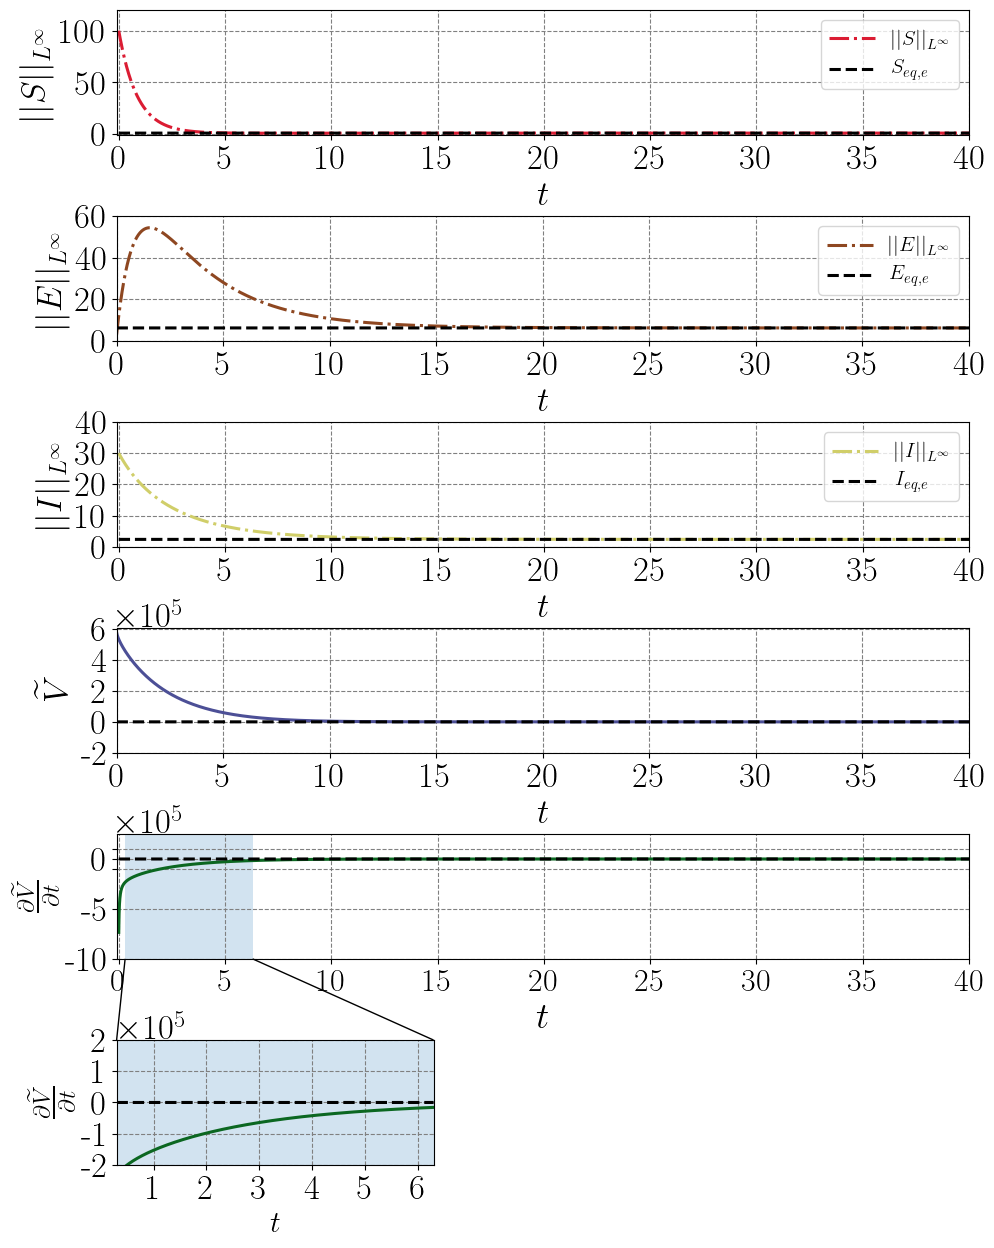

In [6]:
    fig = plt.figure(figsize=(11,15))
    ax = plt.gca()
    rows =6
    columns = 5
    lw=2.2
    grid = plt.GridSpec(rows, columns, wspace = .29, hspace = .65)   
    fontsize_label=25
    legend_size=15

    ax.remove()
    ax =plt.subplot(grid[0, :])
    plt.plot(t, S,'-.', c=colors[3],linewidth = lw)
    plt.plot(t, S_eq_e*np.ones(len(t)), 'k--',linewidth = lw)
    plt.xlim(t[0]-0.1, t[-1])
    plt.ylim(-0.5, 120)
    plt.legend(['$||S||_{L^{\infty}}$', '$S_{eq,e}$'],prop={"size":legend_size},handlelength=2.2,handleheight=0.2,columnspacing=0.25)
    plt.ylabel('$||S||_{L^{\infty}}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
         
    ax =plt.subplot(grid[1, :])
    plt.plot(t, E,'-.', c=colors[8],linewidth = lw)
    plt.plot(t, E_eq_e*np.ones(len(t)), 'k--',linewidth = lw)
    plt.xlim(t[0], t[-1])
    plt.ylim(0, 60)
    plt.legend(['$||E||_{L^{\infty}}$', '$E_{eq,e}$'],prop={"size":legend_size},handlelength=2.2,handleheight=0.2,columnspacing=0.25)
    plt.ylabel('$||E||_{L^{\infty}}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    ax =plt.subplot(grid[2, :])
    plt.plot(t, I, '-.',c=colors[2],linewidth = lw)
    plt.plot(t, I_eq_e*np.ones(len(t)), 'k--',linewidth = lw)
    plt.xlim(t[0]-0.1,t[-1])
    plt.ylim(0, 40)
    plt.legend(['$||I||_{L^{\infty}}$', '$I_{eq,e}$'],prop={"size":legend_size},handlelength=2.2,handleheight=0.2,columnspacing=0.25)
    plt.ylabel('$||I||_{L^{\infty}}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    ax =plt.subplot(grid[3, :])
    plt.plot(t1, L,c=colors[0],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--', linewidth = lw)
    plt.xlim(t1[0], t1[-1])
    ax.set_yticks([-2e5,0,2e5,4e5,6e5])
    plt.text(0.0, 1.03, r'$\times 10^{5}$', fontsize=fontsize_label, weight = 'bold',transform = plt.gca().transAxes)
    plt.ylabel('$\widetilde {V}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=fontsize_label)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda L: "%1.0f" % L, locs*1e-5))
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')

    ax1 =plt.subplot(grid[4, :])
    plt.plot(t1, np.array(dL),c=colors[7],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--',linewidth = lw)
    plt.xlim(t1[0]-0.1,t1[-1])
    plt.ylim(-8e5,2e5)
    plt.ylabel('$\\frac{\partial \widetilde {V}}{\partial t}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=27)
    plt.xticks( weight = 'bold',fontsize=23)
    locs,labels = plt.yticks()
    plt.text(0.0, 1.03, r'$\times 10^{5}$', fontsize=fontsize_label, weight = 'bold',transform = plt.gca().transAxes)
    plt.yticks(locs, map(lambda L: "%1.0f" % L, locs*1e-5))
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    ax1.set_yticks([-10e5,-5e5,-1e5,0,1e5])

    ax2 =plt.subplot(grid[5, 0:2])
    plt.plot(t1, np.array(dL),c=colors[7],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--',linewidth = lw)
    zoom_effect02(ax2, ax1)
    plt.xlim(0.3,6.3)
    plt.ylim(-2e5,2e5)
    plt.ylabel('$\\frac{\partial \widetilde {V}}{\partial t}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=22)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.text(0.01, 1.03, r'$\times 10^{5}$', fontsize=25, weight = 'bold',transform = plt.gca().transAxes)
    plt.yticks(locs, map(lambda L: "%1.0f" % L, locs*1e-5))
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')

    plt.savefig(f"{target}/figure2_SEI_PDE.pdf", bbox_inches="tight")

## (II)  One-dimensional results for the tumor-free equilibrium point for the M1 virotherapy model.

We conducted numerical simulations for the M1 virotherapy PDE model on $\Omega =[0,2]$, and in a time interval $[0, 400]$.

1). The spatio-temporal distributions of nutrients, normal cells, tumor cells, free M1 virus, and immune response.


In [7]:
fontsize_label=20
with io.IO().open("/home/aljahdra/2023-fully-discrete-lyapunov-consistent-discretizations/code/m1virus-grid.dat") as f:
    deg, coord = f.load()
    coord = coord.ravel()
time = []
data = []
for filename in sorted(glob("/home/aljahdra/2023-fully-discrete-lyapunov-consistent-discretizations/code/m1virus-step-*.dat")):
    with io.IO().open(filename) as f:
        n, t, vec = f.load()
        vec.shape = (-1, 5)
        time.append(t)
        data.append(vec)

time = np.stack(time)
data = np.stack(data)

tt, xx = np.meshgrid(time, coord, indexing='ij')
S = data[..., 0]
N = data[..., 1]
T = data[..., 2]
V = data[..., 3]
Z = data[..., 4]


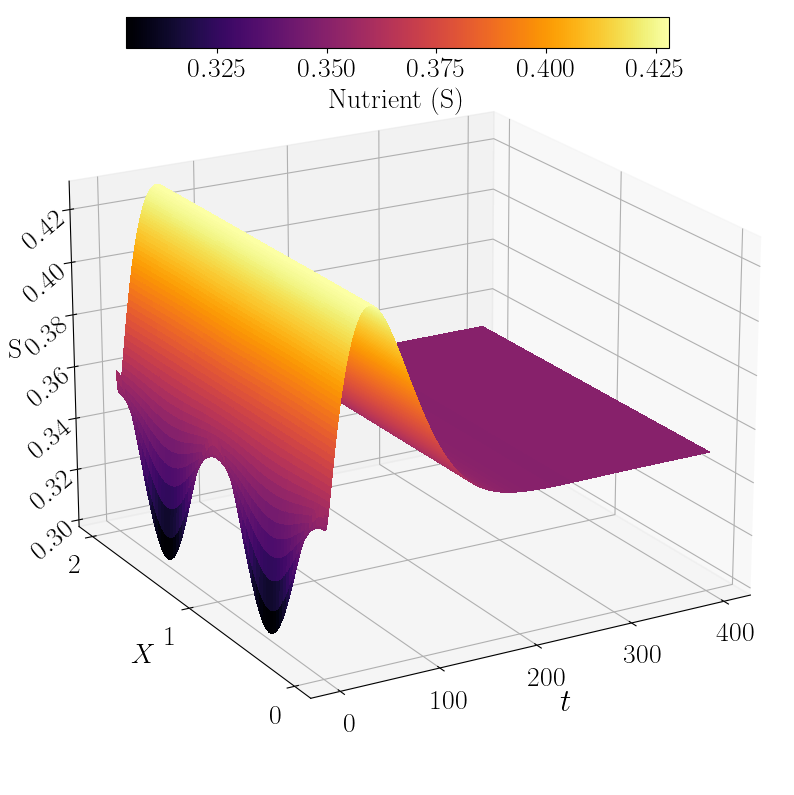

In [8]:
fig = plt.figure(figsize=(10,19))
ax = fig.add_subplot(projection='3d')
ax.view_init(20, -120)
surf = ax.plot_surface(
    tt, xx, S,
    cmap='inferno',
    linewidth=0,
    rcount=5000,
    ccount=5000,
    antialiased=False,
)
plt.xticks( weight = 'bold',fontsize=fontsize_label, rotation=0)
plt.yticks( weight = 'bold',fontsize=fontsize_label, rotation=0)

ax.set_xlabel('$t$', fontsize=23,rotation=0)
ax.set_ylabel('$X$', fontsize=fontsize_label)
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 5
ax.yaxis.labelpad = 10

matplotlib.pyplot.yticks(np.arange(0, 3, step=1))
matplotlib.pyplot.xticks(np.arange(0, 500, step=100))


for tick in ax.zaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize_label)
    tick.label1.set_rotation(40)

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('S', weight = 'bold',fontsize=fontsize_label,rotation = 0)

axins1 = inset_axes(
    ax,
    width="70%",  
    height="4%",  
    loc="upper center",
)
cbar = plt.colorbar(surf, cax=axins1, orientation="horizontal")
cbar.ax.tick_params(labelsize=fontsize_label)
cbar.set_label(label="Nutrient (S)", weight = 'bold',fontsize=20)

plt.savefig(f"{target}/figure_M1virus_1D_S.pdf", bbox_inches="tight")

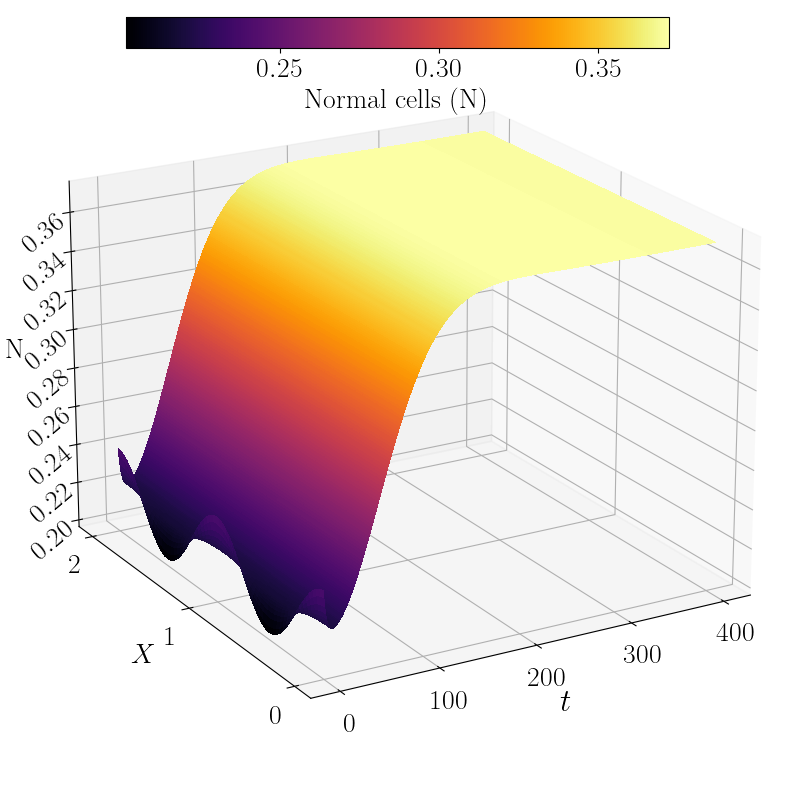

In [9]:
fig = plt.figure(figsize=(10,19))
ax = fig.add_subplot(projection='3d')
ax.view_init(20, -120)
surf = ax.plot_surface(
    tt, xx, N,
    cmap='inferno',
    linewidth=0,
    rcount=4000,
    ccount=4000,
    antialiased=False
)
plt.xticks( weight = 'bold',fontsize=fontsize_label, rotation=0)
plt.yticks( weight = 'bold',fontsize=fontsize_label, rotation=0)

ax.set_xlabel('$t$', fontsize=23,rotation=0)
ax.set_ylabel('$X$', fontsize=fontsize_label)
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 5
ax.yaxis.labelpad = 10

matplotlib.pyplot.yticks(np.arange(0, 3, step=1))
matplotlib.pyplot.xticks(np.arange(0, 500, step=100))


for tick in ax.zaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize_label)
    tick.label1.set_rotation(40)

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('N', weight = 'bold',fontsize=fontsize_label,rotation = 0)

axins1 = inset_axes(
    ax,
    width="70%", 
    height="4%",  
    loc="upper center",
)
cbar = plt.colorbar(surf, cax=axins1, orientation="horizontal")
cbar.ax.tick_params(labelsize=fontsize_label)
cbar.set_label(label="Normal cells (N)", weight = 'bold',fontsize=20)

plt.savefig(f"{target}/figure_M1virus_1D_N.pdf", bbox_inches="tight")

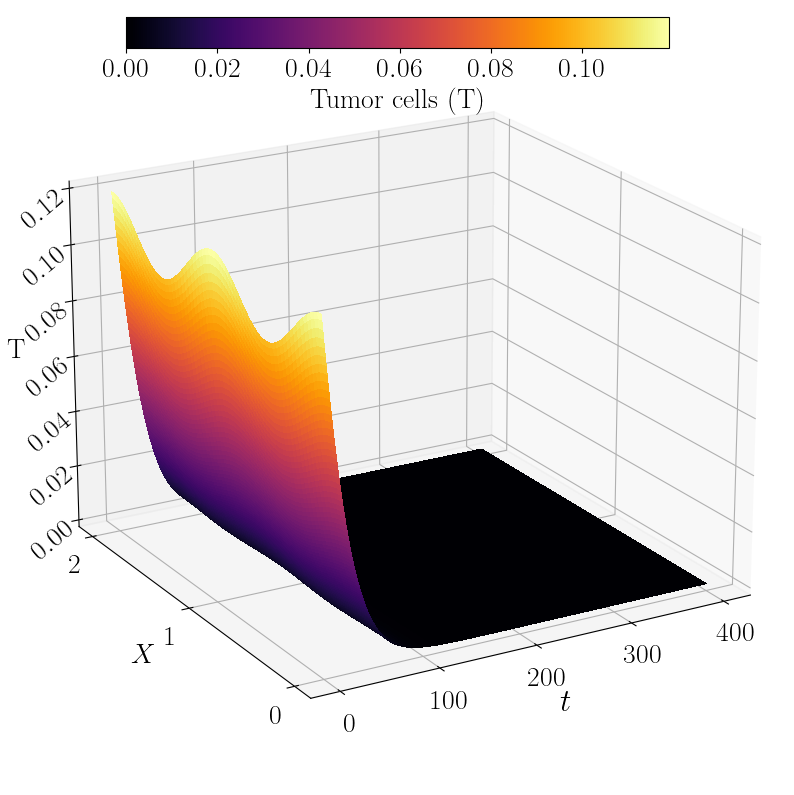

In [10]:
fig = plt.figure(figsize=(10,19))
ax = fig.add_subplot(projection='3d')
ax.view_init(20, -120)
surf = ax.plot_surface(
    tt, xx, T,
    cmap='inferno',
    linewidth=0,
    rcount=4000,
    ccount=4000,
    antialiased=False,
)
plt.xticks( weight = 'bold',fontsize=fontsize_label, rotation=0)
plt.yticks( weight = 'bold',fontsize=fontsize_label, rotation=0)

ax.set_xlabel('$t$', fontsize=23,rotation=0)
ax.set_ylabel('$X$', fontsize=fontsize_label)
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 5
ax.yaxis.labelpad = 10

matplotlib.pyplot.yticks(np.arange(0, 3, step=1))
matplotlib.pyplot.xticks(np.arange(0, 500, step=100))


for tick in ax.zaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize_label)
    tick.label1.set_rotation(40)

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('T', weight = 'bold',fontsize=fontsize_label,rotation = 0)

axins1 = inset_axes(
    ax,
    width="70%",  
    height="4%", 
    loc="upper center",
)
cbar = plt.colorbar(surf, cax=axins1, orientation="horizontal")
cbar.ax.tick_params(labelsize=fontsize_label)
cbar.set_label(label="Tumor cells (T)", weight = 'bold',fontsize=20)

plt.savefig(f"{target}/figure_M1virus_1D_T.pdf", bbox_inches="tight")

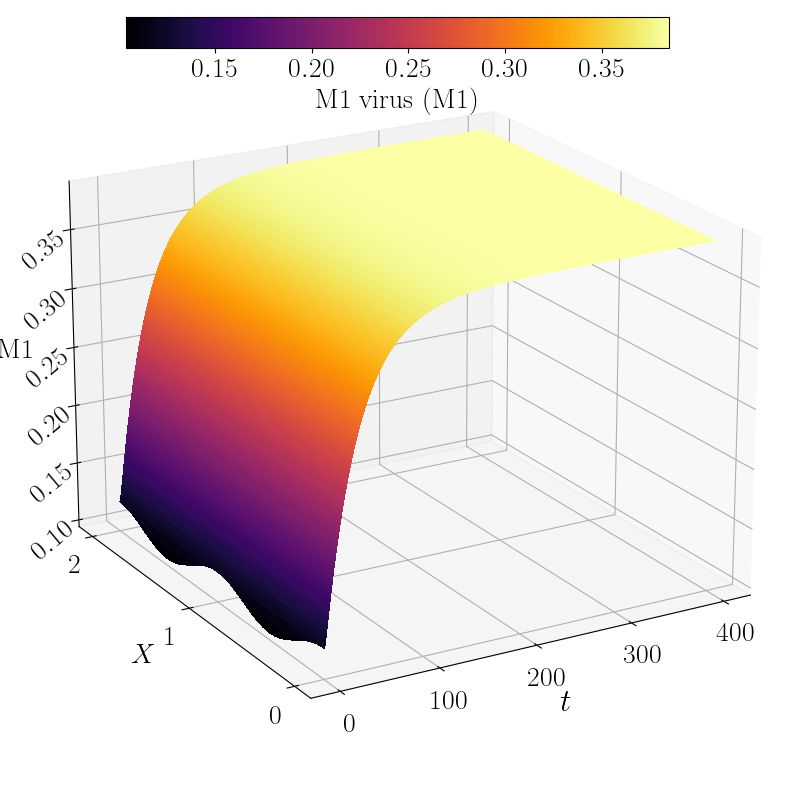

In [11]:
fig = plt.figure(figsize=(10,19))
ax = fig.add_subplot(projection='3d')
ax.view_init(20, -120)
surf = ax.plot_surface(
    tt, xx, V,
    cmap='inferno',
    linewidth=0,
    rcount=4000,
    ccount=4000,
    antialiased=False,
)
plt.xticks( weight = 'bold',fontsize=fontsize_label, rotation=0)
plt.yticks( weight = 'bold',fontsize=fontsize_label, rotation=0)

ax.set_xlabel('$t$', fontsize=23,rotation=0)
ax.set_ylabel('$X$', fontsize=fontsize_label)
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 5
ax.yaxis.labelpad = 10

matplotlib.pyplot.yticks(np.arange(0, 3, step=1))
matplotlib.pyplot.xticks(np.arange(0, 500, step=100))


for tick in ax.zaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize_label)
    tick.label1.set_rotation(40)

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('M1', weight = 'bold',fontsize=fontsize_label,rotation = 0)

axins1 = inset_axes(
    ax,
    width="70%",  
    height="4%",  
    loc="upper center",
)
cbar = plt.colorbar(surf, cax=axins1, orientation="horizontal")
cbar.ax.tick_params(labelsize=fontsize_label)
cbar.set_label(label="M1 virus (M1)", weight = 'bold',fontsize=20)

plt.savefig(f"{target}/figure_M1virus_1D_V.pdf", bbox_inches="tight")

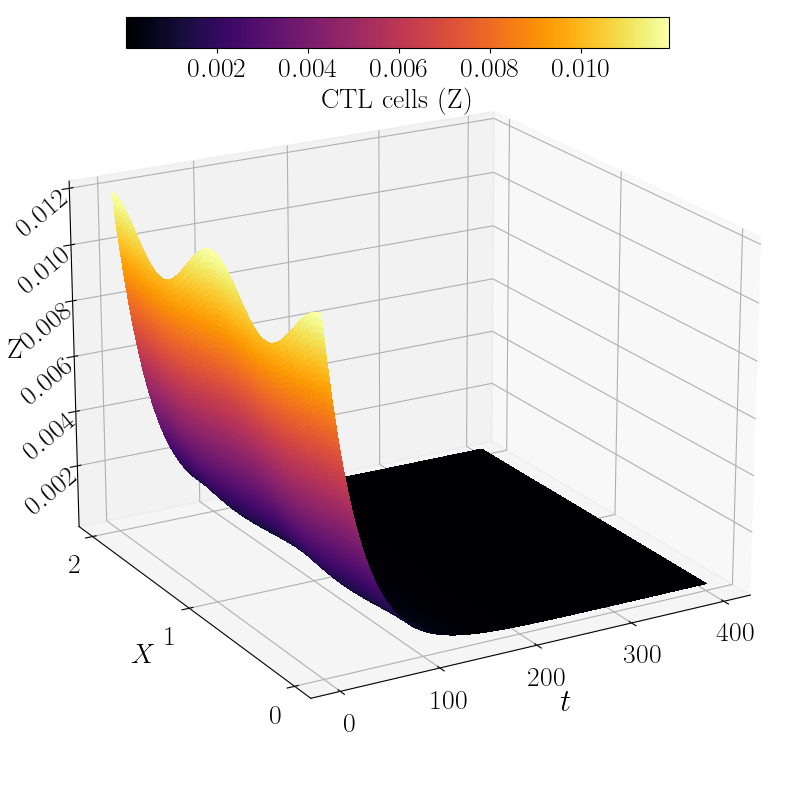

In [12]:
fig = plt.figure(figsize=(10,19))
ax = fig.add_subplot(projection='3d')
ax.view_init(20, -120)
surf = ax.plot_surface(
    tt, xx, Z,
    cmap='inferno',
    linewidth=0,
    rcount=4000,
    ccount=4000,
    antialiased=False,
)
plt.xticks( weight = 'bold',fontsize=fontsize_label, rotation=0)
plt.yticks( weight = 'bold',fontsize=fontsize_label, rotation=0)

ax.set_xlabel('$t$', fontsize=23,rotation=0)
ax.set_ylabel('$X$', fontsize=fontsize_label)
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 5
ax.yaxis.labelpad = 10

matplotlib.pyplot.yticks(np.arange(0, 3, step=1))
matplotlib.pyplot.xticks(np.arange(0, 500, step=100))


for tick in ax.zaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize_label)
    tick.label1.set_rotation(40)

ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Z', weight = 'bold',fontsize=fontsize_label,rotation = 0)

axins1 = inset_axes(
    ax,
    width="70%",  
    height="4%",  
    loc="upper center",
)
cbar = plt.colorbar(surf, cax=axins1, orientation="horizontal")
cbar.ax.tick_params(labelsize=fontsize_label)
cbar.set_label(label="CTL cells (Z)", weight = 'bold',fontsize=20)

plt.savefig(f"{target}/figure_M1virus_1D_Z.pdf", bbox_inches="tight")

2). The temporal evolution of the Lyapunov functional $\widetilde{V}$ and its time derivative $\frac{d\widetilde{V}}{d t}$ .

In [13]:
    t1 = []
    L = []
    dL= []

    time1 = 1
    lyap = 2
    dlyap = 3

    file = open(f"{path}/m1virus-1D-rrk.txt", 'r')
    lines = file.readlines()
    file.close()

    for line in lines:
        t1.append(float(line.split()[time1].split('=')[1]))
        L.append(float(line.split()[lyap].split('=')[1]))
        dL.append(float(line.split()[dlyap].split('=')[1]))

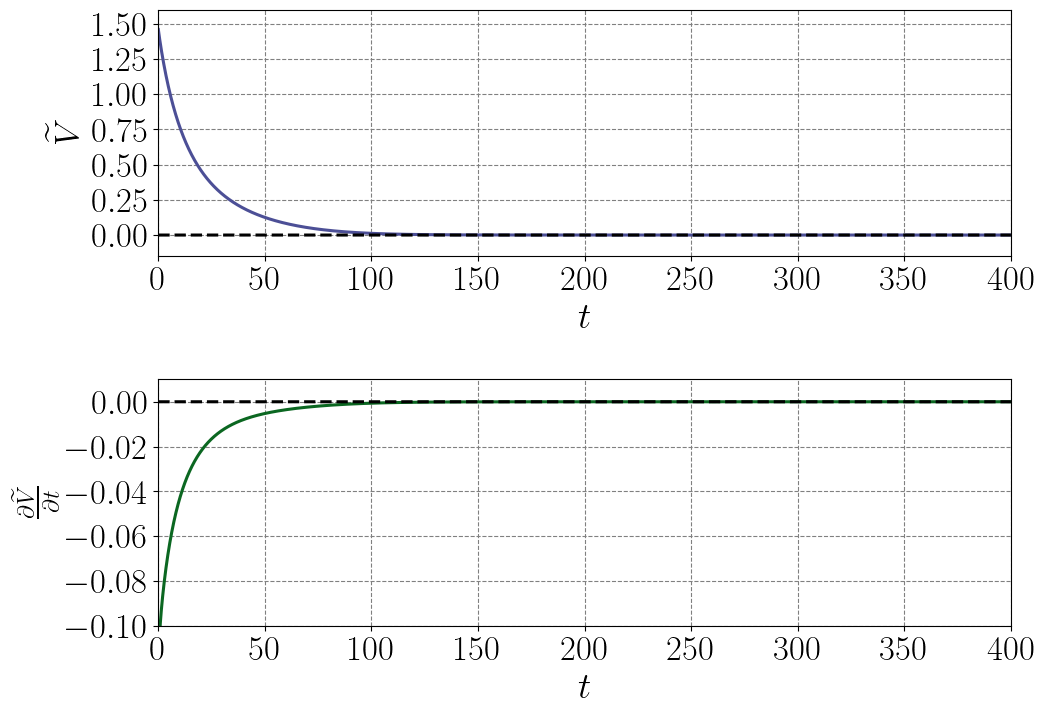

In [14]:
    fig = plt.figure(figsize=(11,8))
    ax = plt.gca()
    rows =2
    columns =2
    lw=2.2
    grid = plt.GridSpec(rows, columns, wspace = .35, hspace = .5)   
    fontsize_label=25

    ax.remove()
    ax =plt.subplot(grid[0, :])
    plt.plot(t1, L,c=colors[0],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--', linewidth = lw)
    plt.xlim(t1[0], t1[-1])
    plt.ylim(-0.15, 1.6)
    plt.ylabel('$\widetilde{V}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=27)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    ax =plt.subplot(grid[1, :])
    plt.plot(t1, np.array(dL),c=colors[7],linewidth = lw)
    plt.plot(t1, np.zeros(len(t1)), 'k--',linewidth = lw)
    plt.xlim(t1[0],t1[-1])
    plt.ylim(-10e-2, 1e-2)
    plt.ylabel('$\\frac{\partial\widetilde{V}}{\partial t}$', fontsize=fontsize_label)
    plt.xlabel('$t$', fontsize=27)
    plt.xticks( weight = 'bold',fontsize=fontsize_label)
    locs,labels = plt.yticks()
    plt.yticks( weight = 'bold',fontsize=fontsize_label)
    plt.grid(visible=True, which='major', c=colors[4], linestyle='--')
    
    plt.savefig(f"{target}/figure_m1virus-lyap-1D.pdf", bbox_inches="tight")